In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("error")

In [2]:
movies = pd.read_csv('3b movies_GloVe.csv')
country_codes = pd.read_csv('country_codes.csv')

In [3]:
def get_numbers(str):
    """Return the integer numbers from a string in an array format."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').split()
    arr = [int(s) for s in arr if s.isdigit()]
    return arr

def get_country_codes(str):
    """Return the codes of the countries from a string."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').replace("'", "").split()
    arr = [s for s in arr if country_codes['Code'].str.contains(s).any()]
    return arr

def prepare_dataframe(movies):
    
    movies = movies.drop(['id', 'title'], axis=1)
    
    # Categorical values are not used, because of the algorithm
    numeric = movies.drop(['adult', 'genres', 'original_language', 'production_companies', 'production_countries'], axis=1)
    
    # Scale the numeric values to (0, 1) interval
    scaler = MinMaxScaler()
    numeric = scaler.fit_transform(numeric)
    
    movievectors = pd.DataFrame(numeric)
    
    return movievectors

In [4]:
movies = prepare_dataframe(movies)

In [5]:
# 1. test: PCA vs random dimension cut, with 5 clusters
df1 = pd.DataFrame(columns=['Number of dimensions','Silhouette score with PCA', 'Silhouette score with random cut'])
clusters = 5
for dimensions in range(movies.shape[1], 2, -2):
    
    # PCA
    pca = PCA(n_components=dimensions)
    reduced_data_PCA = pca.fit_transform(movies)
    
    for thres in np.arange(0.5, 0, -0.05):
        try:
            birch_PCA = Birch(threshold=thres)
            birch_PCA.fit(reduced_data_PCA)
            break
        except:
            pass
        
    
    silscore_PCA = silhouette_score(reduced_data_PCA, birch_PCA.predict(reduced_data_PCA))
    
    # Random dimension cut
    reduced_data_rand = movies.sample(n=dimensions, axis='columns')
    
    for thres in np.arange(0.5, 0, -0.05):
        try:
            birch_rand = Birch(threshold=thres)
            birch_rand.fit(reduced_data_rand)
            break
        except:
            pass
    
    silscore_rand = silhouette_score(reduced_data_rand, birch_rand.predict(reduced_data_rand))
    
    scores = pd.DataFrame([[dimensions, silscore_PCA, silscore_rand]],
                          columns=['Number of dimensions','Silhouette score with PCA', 'Silhouette score with random cut'])
    df1 = pd.concat([df1, scores], axis=0)

In [6]:
df1 = df1.reset_index().drop('index', axis=1)

<AxesSubplot:xlabel='Number of dimensions', ylabel='Silhouette Score'>

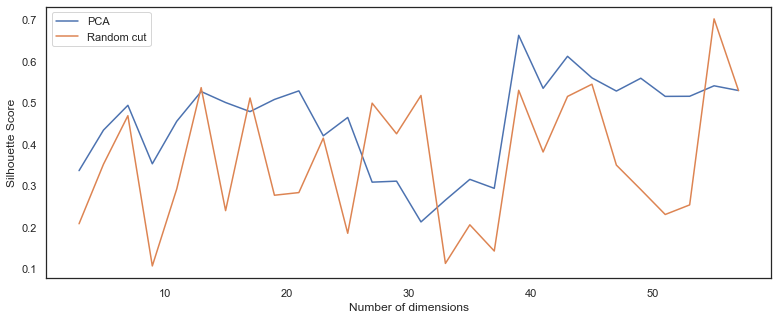

In [7]:
# Visualize the results
sns.set_theme(style="white")
plt.figure(figsize=(13,5))
plt.ylabel('Silhouette Score')

sns.lineplot(data = df1, x='Number of dimensions', y='Silhouette score with PCA', label='PCA')
sns.lineplot(data = df1, x='Number of dimensions', y='Silhouette score with random cut', label='Random cut')

In [8]:
df1

,Number of dimensions,Silhouette score with PCA,Silhouette score with random cut
0,57,0.529081,0.529081
1,55,0.540474,0.701842
2,53,0.515221,0.253386
3,51,0.514966,0.230276
4,49,0.558721,0.290332
5,47,0.527813,0.349325
6,45,0.559559,0.544291
7,43,0.611569,0.514840
8,41,0.534374,0.380920
9,39,0.662184,0.529629


In [16]:
# 2. test: Measure matching of original clustering and clustering after PCA
dimensions = 39

for thres in np.arange(0.5, 0, -0.05):
        try:
            birch_all = Birch(threshold=thres)
            birch_all.fit(movies)
            break
        except:
            pass

pca = PCA(n_components=dimensions)
reduced_data_PCA = pca.fit_transform(movies)

for thres in np.arange(0.5, 0, -0.05):
        try:
            birch_PCA = Birch(threshold=thres)
            birch_PCA.fit(reduced_data_PCA)
            break
        except:
            pass

In [17]:
all_data_clusters = birch_all.predict(movies)
after_pca_clusters = birch_PCA.predict(reduced_data_PCA)

In [18]:
sum(all_data_clusters == after_pca_clusters)

126

In [19]:
# As percentage of all movies
sum(all_data_clusters == after_pca_clusters) / movies.shape[0]

0.0028383492521174987